<a href="https://colab.research.google.com/github/kdemertzis/Earthquakes/blob/main/ITSAK/latex_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!apt install texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import sympy
np.set_printoptions(suppress=True)

In [62]:
# Load the earthquake dataset
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Earthquakes/main/ITSAK/ln_1_no_titles.csv')


In [63]:
# Split the data into input and output arrays
X = data.iloc[:, :-1].values # Select all columns except the last
y = data.iloc[:, -1].values  # Select the last column as the output

In [64]:
# Scale the data
scale_X = MinMaxScaler()
X = scale_X.fit_transform(X)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(y.reshape(-1,1))

In [65]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Define and run model
model = Sequential()
model.add(Dense(1, input_dim=4, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1, name='Output'))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

In [67]:
# Predict on test set
yhat = model.predict(X_test)

17/17 [==============================] - 0s 1ms/step


In [68]:
# Inverse transforms
X_plot = scale_X.inverse_transform(X_test)
y_plot = scale_y.inverse_transform(y_test)
yhat_plot = scale_y.inverse_transform(yhat)

In [69]:
# Print evaluation metrics
print("R-squared:", r2_score(y_test, yhat))
print("Mean squared error:", mean_squared_error(y_test, yhat))

R-squared: 0.8506150407632103
Mean squared error: 0.005570705032206471


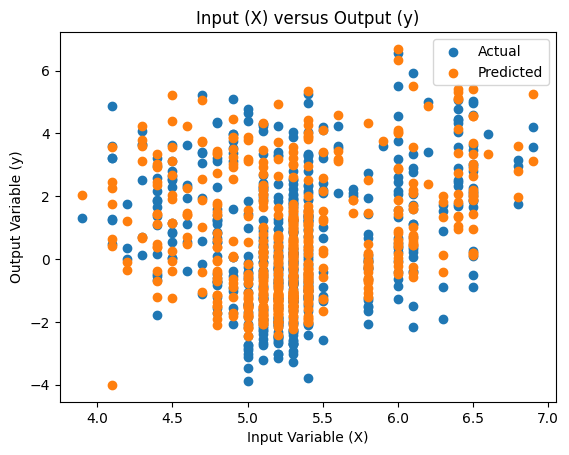

In [70]:
# Plot X_test vs y_test and yhat
plt.scatter(X_plot[:, 0], y_plot, label='Actual')
plt.scatter(X_plot[:, 0], yhat_plot, label='Predicted')
plt.title('Input (X) versus Output (y)')
plt.xlabel('Input Variable (X)')
plt.ylabel('Output Variable (y)')
plt.legend()
plt.show()

In [71]:
### Conversion to Basic Formula

# temp list as a container for each layer formulas
formula_list = []
# counter of hidden layers
f_n = 1
#
for i in range(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[i]
    W = layer.get_weights()
    # empty text string to which concatenate current layer formula parts
    formula = ''
    # set script for input layer
    if i == 0:
        for i in range(W[0].shape[1]):
            cur_weight = np.sum(W[0][0,i])
            cur_bias = np.sum(W[1][i])
            # build formula for this layer
            formula += '*'+str(np.round(cur_weight,2))+'*'+'x+'+'*'+str(np.round(cur_bias,2)) + '*'+ '/'
        # append this layer formula to temp list
        formula_list.append(formula)

    # set script for hidden layers
    elif i < len(model.layers)-1:
        # start loop for next layer each neuron
        for c in range(W[0].shape[1]):
            cur_bias = np.sum(W[1][c])
            for i in range(W[0].shape[0]):
                cur_weight = np.sum(W[0][i, c])
                # build formula for this layer using previous layer formula
                formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
            formula += '*'+str(np.round(cur_bias,2))+'*' + '/'
        # append this layer formula to temp list
        formula_list.append(formula)
        # increase index number for the next hidden layer
        f_n+=1
    # set script for output layer
    else:
        for i in range(W[0].shape[0]):
            cur_weight = np.sum(W[0][i, 0])
            # build formula for this layer using previous layer formula
            formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
        cur_bias = np.sum(W[1][0])
        formula += '*'+str(np.round(cur_bias,2))+'*'
        # append this layer formula to temp list
        formula_list.append(formula)
# get last formula
formula = formula_list[-1]
# make some cleanings
formula = formula.replace('+*-','-')
formula = formula.replace('+*0.0*','')
formula = formula.replace('-*0.0*','')
formula = formula.replace('*','')
print(formula)

1.11f1(0.47x+1.76)f1+0.02


In [75]:
# create LaTeX code
def latex_activation_function(x):
    return '\frac{e^{'+x+'} - e^{-'+x+'}}{e^{'+x+'} + e^{-'+x+'}}'


formula_latex = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_latex).group(1)
            start = re.search(pattern, formula_latex).start()
            formula_latex = formula_latex[:start] + latex_activation_function(substring) + formula_latex[start + 4 + len(substring):]
        except:
            exist = False

print(formula_latex)

1.11rac{e^{(0.47x+1.76)} - e^{-(0.47x+1.76)}}{e^{(0.47x+1.76)} + e^{-(0.47x+1.76)}}+0.02


In [76]:
# Create numpy formula
def numpy_activation_function(x):
    return '(np.exp('+x+') - np.exp(-'+x+'))/(np.exp('+x+') + np.exp(-'+x+'))'


formula_numpy = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_numpy).group(1)
            start = re.search(pattern, formula_numpy).start()
            formula_numpy = formula_numpy[:start] + numpy_activation_function(substring) + formula_numpy[start + 4 + len(substring):]
        except:
            exist = False

formula_numpy = formula_numpy.replace('(np', '*(np')
formula_numpy = formula_numpy.replace('x-', '*x-')
formula_numpy = formula_numpy.replace('x+', '*x+')
formula_numpy = formula_numpy.replace('/*', '/')

print(formula_numpy)

1.11*(np.exp((0.47*x+1.76)) - np.exp(-(0.47*x+1.76)))/(np.exp((0.47*x+1.76)) + np.exp(-(0.47*x+1.76)))+0.02


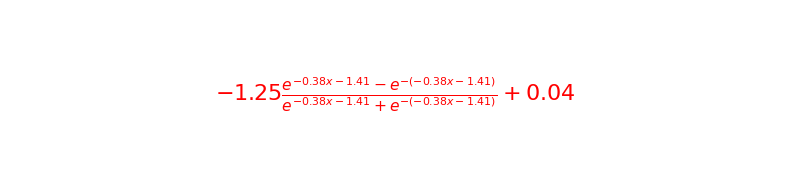

In [79]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
rc("text", usetex=False)
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)
ax.set_axis_off()
ax.text(0.5,0.5,r'$'+formula_latex+'$', fontsize=16, color='r', ha='center', va='center')
plt.show()
     